# COGS 108 - Final Project 

# Overview

The goal of such a study is to examine the potential link between minority populations in neighborhoods and the likelihood that restaurants present in that neighborhood are to receive health and safety related violations. Prior research has had conflicting results, and this study aims to help clarify the relationship. The results indicate there is seemingly no correlation between minority populations and health and safety violation, but the author recommends further study.

# Name & GitHub ID

- Name: Spencer Liu
- GitHub Username: spencer-liu

# Research Question

Are restaurants in low-income neighborhoods with high minority populations more likely to receive health and safety violations in their health inspections compared to their majority white populations?

## Background and Prior Work

As both implicit and explicit racial bias have become more of a public issue, research into the sociodeomgraphic factors behind health inspections, inspection frequency, and the likelihood of violations being found has begun. <br>
While neighborhoods with high African American populations have been found to have fewer food borne illness violations, there has been a link between African American neighborhoods and more good retail practice violations[1]. <br>
There have been worries among ethnic restaurants serving non-western foods of failing health inspections due to preconceptions of the cultures involved[2], with research conflicting with a prior research source indicating that ethnic operated restaurants had statistically significant high rates of inspections and critical violations[3]. <br>
Furthermore, with the greater reliance of health inspection governing bodies relying on public domain reviews such as yelp to make judgements, the link between potential preconceptions of an ethnic operated restaurant has been made more and more public[4].

References (include links):
- 1)https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5349477/
- 2)https://www.researchgate.net/publication/273400616_Food_safety_inspections_results_A_comparison_of_ethnic-operated_restaurants_to_non-ethnic-operated_restaurants
- 3)https://www.gothamgazette.com/index.php/health/568-ethnic-restaurants-worry-they-wont-make-the-grade
- 4)https://slate.com/human-interest/2014/06/ethnic-restaurants-and-food-poisoning-the-subtle-racism-of-saying-chinese-food-caused-your-stomachache.html

# Hypothesis


Restaurants in high minority neighborhoods are more likely to receive health and safety violations health inspections compared to low income white majority neighborhood restaurants.

# Dataset(s)

- Dataset Name: violations.csv
- Link to the dataset: https://canvas.ucsd.edu/courses/18744/files/2120497/download?wrap=1
- Path to the dataset: /home/spl019/Final\ Project/violations.csv
- Number of observations: 207301

The dataset is a comma delimited csv file containing the id of the restaurant the violation applies to and the type of violation present.

- Dataset Name: inspections.csv
- Link to the dataset: https://canvas.ucsd.edu/courses/18744/files/2120497/download?wrap=1
- Path to the dataset: /home/spl019/Final\ Project/inspections.csv
- Number of observations: 21109

The dataset is a comma delimited csv file containing indentification information for the facility, type of facility, current and previous violation counts, overall score, and facility address.

- Dataset Name: restaurants.csv
- Link to the dataset: https://canvas.ucsd.edu/courses/18744/files/2120497/download?wrap=1
- Path to the dataset: /home/spl019/Final\ Project/restaurants.csv
- Number of observations: 3325

The dataset is a comma delimited csv file containing the id of the restaurant, type of restaurant, location information, contact information, and whether it is located through the geocode api.

- Dataset Name: zipcodes.csv
- Link to the dataset: https://canvas.ucsd.edu/courses/18744/files/2120497/download?wrap=1
- Path to the dataset: /home/spl019/Final\ Project/zipcodes.csv
- Number of observations: 39

The dataset is a comma delimited csv file containing zip codes, the median household and family incomes, per capita income, economic statistic,s and racial statistics for each zip code.

# Setup

In [1]:
#imports for the Assignment
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import markdown as md

# Data Cleaning

### Setup datasets

In [2]:
violations = pd.read_csv("violations.csv")
zipcodes = pd.read_csv("zipcodes.csv")
restaurants = pd.read_csv("restaurants.csv")
inspections = pd.read_csv("inspections.csv")

### Clean Violations Dataset

In [3]:
violationTags = ["Approved Source", "Consumer Advisory", "Conformance with Approved Procedures", "Food Temperature Control", "Good Hygienic Practices", "Physical Facilities", "Potentially Hazardous Food Time/Temperature", "Preventing Contamination by Hands", "Prevention of Food Contamination", "Protection from Contamination", "Safe Food and Water"]
violations = violations.loc[violations["category"].isin(violationTags)]
violations = violations["hsisid"]
violations = violations.reset_index()

### Clean Inspections Dataset

In [4]:
geocodeStat = ["M", "T"]
inspections = inspections[["hsisid", "facilitytype", "geocodestatus", "zip", "num_critical", "num_non_critical", "num_critical_previous", "num_non_critical_previous"]]
inspections = inspections.loc[((inspections["num_critical"] > 0) | (inspections["num_non_critical"] > 0)) & ((inspections["num_critical_previous"] > 0) | (inspections["num_non_critical_previous"] > 0)) & (inspections["geocodestatus"].isin(geocodeStat)) & (inspections['facilitytype'] == "Restaurant")]
inspections = inspections.reset_index()

### Clean Restaurants Dataset

In [5]:
restaurants = restaurants[["hsisid", "name", "facilitytype", "geocodestatus"]]
restaurants = restaurants.loc[(restaurants["geocodestatus"].isin(geocodeStat)) & (restaurants['facilitytype'] == "Restaurant")]
restaurants = restaurants.reset_index()

### Clean Zip Codes Dataset

In [6]:
zipcodes = zipcodes[["zip", "percent_families_below_poverty_line", "percent_nonwhite"]]
medPovLine = zipcodes["percent_families_below_poverty_line"].median()
zipcodes = zipcodes.loc[zipcodes["percent_families_below_poverty_line"] >= medPovLine]

### Unify Dataset

In [7]:
dataset = pd.merge(inspections, zipcodes, on='zip')
dataset = pd.merge(dataset, restaurants, on='hsisid')
dataset = dataset[['hsisid', 'num_critical', 'num_non_critical', 'num_critical_previous', 'num_non_critical_previous', 'name', 'percent_nonwhite']]
dataset = pd.merge(violations, dataset, on='hsisid')
dataset = dataset.drop_duplicates(subset=['hsisid', 'name'], keep='first')
dataset['num_overall'] = dataset['num_critical'] + dataset['num_non_critical']
dataset['num_overall_prev'] = dataset['num_critical_previous'] + dataset['num_non_critical_previous']

### Clean Up Indices and Columns

In [8]:
dataset = dataset.reset_index()
del dataset['level_0']
del dataset['index']
dataset = dataset.dropna()
dataset = dataset.sort_values(by='percent_nonwhite')

# Data Analysis & Results

### Current Critical vs. Current Non-Critical
First, a pair of scatter plots is generated to compare correlation of current critical health and safety violations against non-critical health and safety violations, along with 1st, second, and fourth degree regression lines being plotted and correlation r values being found.

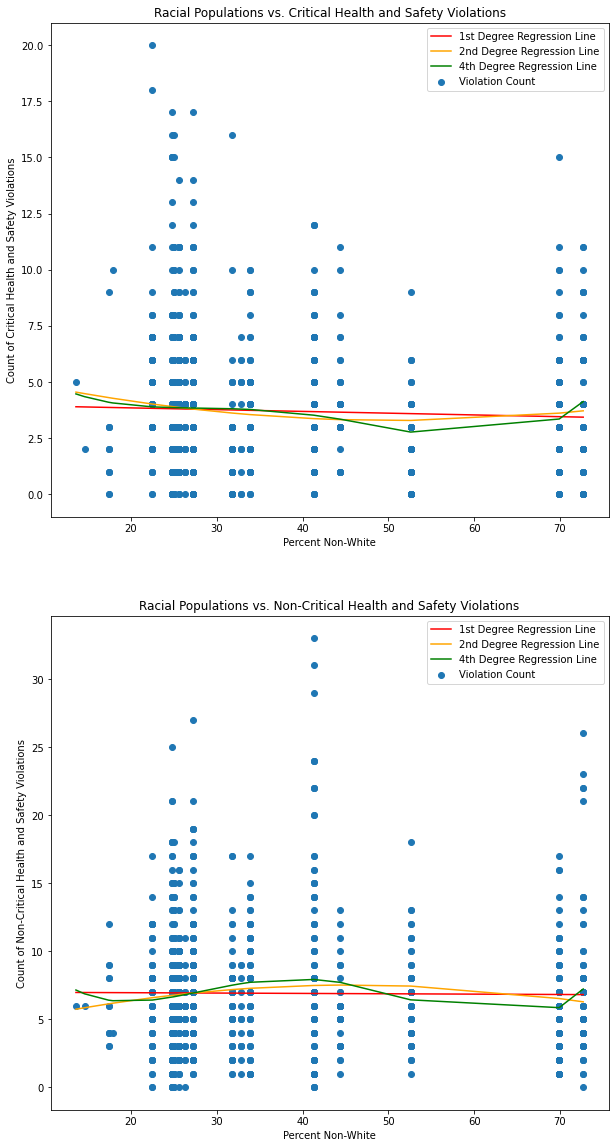

In [9]:
fig, ax = plt.subplots(2, figsize=(10,20))

#Prepare data
x = dataset['percent_nonwhite']
y1 = dataset['num_critical']
y2 = dataset['num_non_critical']

# Regression lines for plot 1
m1, b11 = np.polyfit(x, y1, 1)
a11, b12, c11 = np.polyfit(x, y1, 2)
a12, b13, c12, d1, e1 = np.polyfit(x, y1, 4)
corr1 = x.corr(y1)

# Regression lines for plot 2
m2, b21 = np.polyfit(x, y2, 1)
a21, b22, c21 = np.polyfit(x, y2, 2)
a22, b23, c22, d2, e2 = np.polyfit(x, y2, 4)
corr2 = x.corr(y2)

# Plot scatter plot 1
ax[0].scatter(x, y1)

# Plot regression lines for plot 1
ax[0].plot(x, m1 * x + b11, color='red')
ax[0].plot(x, a11 * pow(x, 2) + b12 * x + c11, color='orange')
ax[0].plot(x, a12 * pow(x, 4) + b13 * pow(x, 3) + c12 * pow(x, 2) + d1 * x + e1, color='green')

# Title, axis, and legend
ax[0].set_xlabel("Percent Non-White")
ax[0].set_ylabel("Count of Critical Health and Safety Violations")
ax[0].legend(['1st Degree Regression Line', '2nd Degree Regression Line', '4th Degree Regression Line', 'Violation Count'])
ax[0].set_title("Racial Populations vs. Critical Health and Safety Violations")

# Plot scatter plot 2
ax[1].scatter(x, y2)

# Plot regression lines for plot 2
ax[1].plot(x, m2 * x + b21, color='red')
ax[1].plot(x, a21 * pow(x, 2) + b22 * x + c21, color='orange')
ax[1].plot(x, a22 * pow(x, 4) + b23 * pow(x, 3) + c22 * pow(x, 2) + d2 * x + e2, color='green')

# Title, axis, and legend
ax[1].set_xlabel("Percent Non-White")
ax[1].set_ylabel("Count of Non-Critical Health and Safety Violations")
ax[1].legend(['1st Degree Regression Line', '2nd Degree Regression Line', '4th Degree Regression Line', 'Violation Count'])
ax[1].set_title("Racial Populations vs. Non-Critical Health and Safety Violations")

# Show Plot
plt.show()

### Previous Critical vs. Previous Non-Critical
A pair of scatter plots is generated to compare correlation of previous critical health and safety violations against previous non-critical health and safety violations, along with 1st, second, and fourth degree regression lines being plotted and correlation r values being found.

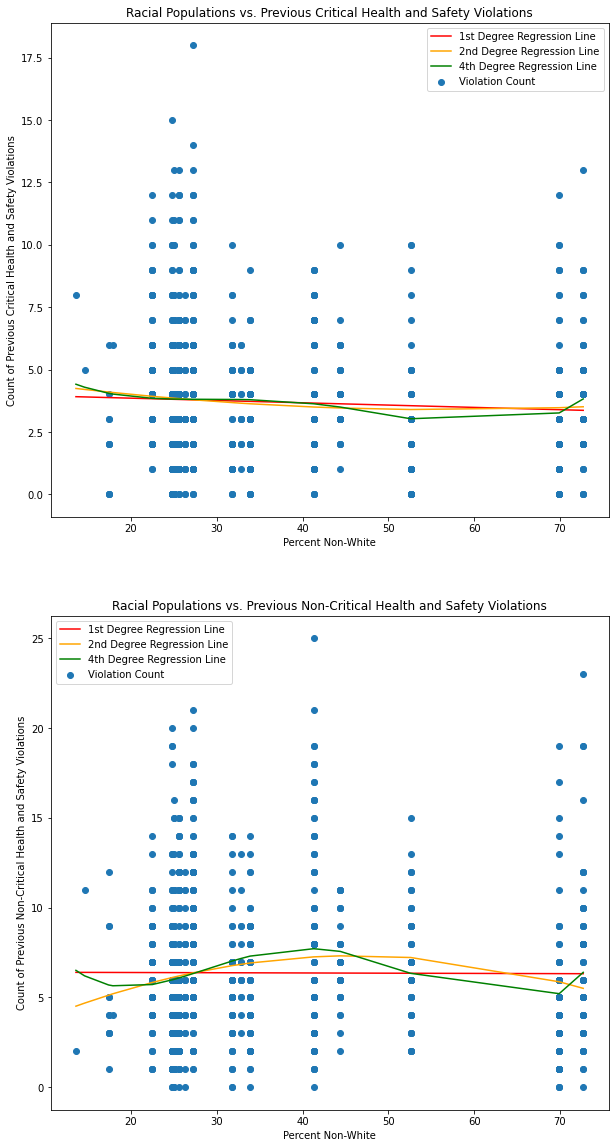

In [10]:
fig, ax = plt.subplots(2, figsize=(10,20))

#Prepare data
y1 = dataset['num_critical_previous']
y2 = dataset['num_non_critical_previous']

# Regression lines for plot 1
m1, b11 = np.polyfit(x, y1, 1)
a11, b12, c11 = np.polyfit(x, y1, 2)
a12, b13, c12, d1, e1 = np.polyfit(x, y1, 4)
corr3 = x.corr(y1)

# Regression lines for plot 2
m2, b21 = np.polyfit(x, y2, 1)
a21, b22, c21 = np.polyfit(x, y2, 2)
a22, b23, c22, d2, e2 = np.polyfit(x, y2, 4)
corr4 = x.corr(y2)

# Plot scatter plot 1
ax[0].scatter(x, y1)

# Plot regression lines for plot 1
ax[0].plot(x, m1 * x + b11, color='red')
ax[0].plot(x, a11 * pow(x, 2) + b12 * x + c11, color='orange')
ax[0].plot(x, a12 * pow(x, 4) + b13 * pow(x, 3) + c12 * pow(x, 2) + d1 * x + e1, color='green')

# Title, axis, and legend
ax[0].set_xlabel("Percent Non-White")
ax[0].set_ylabel("Count of Previous Critical Health and Safety Violations")
ax[0].legend(['1st Degree Regression Line', '2nd Degree Regression Line', '4th Degree Regression Line', 'Violation Count'])
ax[0].set_title("Racial Populations vs. Previous Critical Health and Safety Violations")

# Plot scatter plot 2
ax[1].scatter(x, y2)

# Plot regression lines for plot 2
ax[1].plot(x, m2 * x + b21, color='red')
ax[1].plot(x, a21 * pow(x, 2) + b22 * x + c21, color='orange')
ax[1].plot(x, a22 * pow(x, 4) + b23 * pow(x, 3) + c22 * pow(x, 2) + d2 * x + e2, color='green')

# Title, axis, and legend
ax[1].set_xlabel("Percent Non-White")
ax[1].set_ylabel("Count of Previous Non-Critical Health and Safety Violations")
ax[1].legend(['1st Degree Regression Line', '2nd Degree Regression Line', '4th Degree Regression Line', 'Violation Count'])
ax[1].set_title("Racial Populations vs. Previous Non-Critical Health and Safety Violations")

# Show Plot
plt.show()

### Current Overall vs. Previous Overall
A pair of scatter plots is generated to compare correlation of current overall health and safety violations against previous overall health and safety violations, along with 1st, second, and fourth degree regression lines being plotted and correlation r values being found.

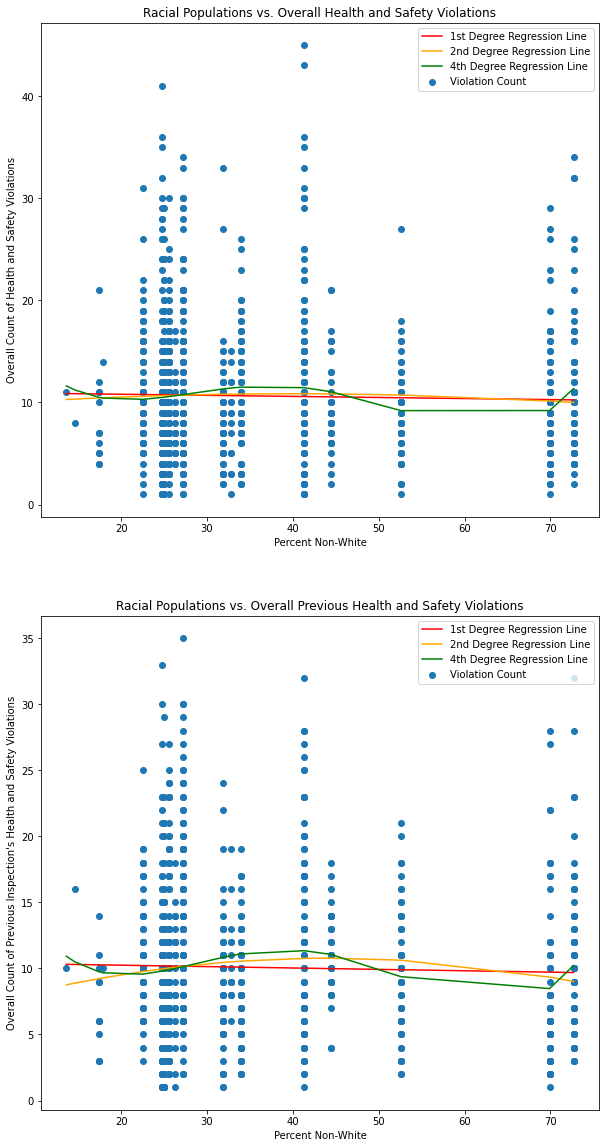

In [11]:
fig, ax = plt.subplots(2, figsize=(10,20))

#Prepare data
y1 = dataset['num_overall']
y2 = dataset['num_overall_prev']

# Regression lines for plot 1
m1, b11 = np.polyfit(x, y1, 1)
a11, b12, c11 = np.polyfit(x, y1, 2)
a12, b13, c12, d1, e1 = np.polyfit(x, y1, 4)
corr5 = x.corr(y1)

# Regression lines for plot 2
m2, b21 = np.polyfit(x, y2, 1)
a21, b22, c21 = np.polyfit(x, y2, 2)
a22, b23, c22, d2, e2 = np.polyfit(x, y2, 4)
corr6 = x.corr(y2)

# Plot scatter plot 1
ax[0].scatter(x, y1)

# Plot regression lines for plot 1
ax[0].plot(x, m1 * x + b11, color='red')
ax[0].plot(x, a11 * pow(x, 2) + b12 * x + c11, color='orange')
ax[0].plot(x, a12 * pow(x, 4) + b13 * pow(x, 3) + c12 * pow(x, 2) + d1 * x + e1, color='green')

# Title, axis, and legend
ax[0].set_xlabel("Percent Non-White")
ax[0].set_ylabel("Overall Count of Health and Safety Violations")
ax[0].legend(['1st Degree Regression Line', '2nd Degree Regression Line', '4th Degree Regression Line', 'Violation Count'])
ax[0].set_title("Racial Populations vs. Overall Health and Safety Violations")

# Plot scatter plot 2
ax[1].scatter(x, y2)

# Plot regression lines for plot 2
ax[1].plot(x, m2 * x + b21, color='red')
ax[1].plot(x, a21 * pow(x, 2) + b22 * x + c21, color='orange')
ax[1].plot(x, a22 * pow(x, 4) + b23 * pow(x, 3) + c22 * pow(x, 2) + d2 * x + e2, color='green')

# Title, axis, and legend
ax[1].set_xlabel("Percent Non-White")
ax[1].set_ylabel("Overall Count of Previous Inspection's Health and Safety Violations")
ax[1].legend(['1st Degree Regression Line', '2nd Degree Regression Line', '4th Degree Regression Line', 'Violation Count'])
ax[1].set_title("Racial Populations vs. Overall Previous Health and Safety Violations")

# Show Plot
plt.show()

In [12]:
print(corr1)
print(corr2)
print(corr3)
print(corr4)
print(corr5)
print(corr6)

-0.04162324583000419
-0.009282911339576759
-0.055975760628955804
-0.005081482034585309
-0.025075072046673554
-0.029103156977138014


### Interpreting Results
In all of the generated graphs, the regression line fails to indicate any strong relationship between the race statistics of a particular zipcode and the likelihood that an establishment located in such a region will receive a violation from the health inspector. <br>
For each graph, an r-value used to represent correlation was found, the absolute value of each being less than 0.5, indicating that the two datasets do not appear to have any correlating relationship.

# Ethics & Privacy

Doing research on sensitive topics such as race and bias from governing bodies against minority populations may lead people to make conclusions based off of only one study or allow for a singular study to be used to support false conclusions. Therefore, it is important to take every available measure to reduce possible bias and adhere to basic ethical principles, as well as to encourage readers to view multiple conflicting studies. <br>
While the data used was public domain, as it concerns people's businesses and neighborhoods, it is imperitive that such data is anonymized to avoid negatively impacting people's livelihoods. <br>
After the study is completed, it will be published online.

# Conclusion & Discussion

The hypothesis formed was that there would be a non-trivial relationship between high minority populations for zip codes and higher likelihood that the restaurant would receive more general health and safety infraction when inspected by a health inspector. <br>
The basis for the hypothesis was built around the prior research indicating that restaurants serving ethnic foods were more likely to receive infractions in both chain and nonchain restaurants. <br>
The results were unable to find a valid best fit regression line which would indicate a relationship between minority population and the number of violations received both recently and in past inspections. <br>
As such, this analysis concludes there is seemingly no relationship between the two factors. <br>
However, it is possible that limiting the data to only impoverished zip codes may have confounded the data and future analysis is recommended. Furthermore, removing chain restaurants or researching other regions of the United States may indicate different results.